In [1]:
# Import Tensorflow & Pathlib librairies
import tensorflow as tf 
import pathlib 
import pandas as pd 
import numpy as np
import os
import io
import warnings
import keras
import regex as re
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D,Conv2D,Dropout,MaxPooling1D,Flatten
from unidecode import unidecode
import en_core_web_md
nlp = en_core_web_md.load()
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix

EDA

In [2]:
train = pd.read_csv('train.csv')

In [3]:
train.shape

(7613, 5)

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
train.target.mean()

0.4296597924602653

The missing values of the "keyword" column represent less than 1% of the dataset, it is kept.
We eliminate the "location" column to have too many missing values.

In [7]:
train = train[[col for col in train.columns if col != 'location']]
train.head()

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1


We look at the unique values of the 'keyword' column.

In [8]:
train['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

We replace the "%20" with a space.

In [9]:
def replace20(x):
    
    try: 
        return x.replace('%20',' ')
    except AttributeError:
        return x

train['keyword'] = train['keyword'].apply(replace20)

train.head()

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
train.groupby('keyword')['target'].mean().sort_values(ascending = False)

keyword
debris        1.000000
wreckage      1.000000
derailment    1.000000
outbreak      0.975000
oil spill     0.973684
                ...   
body bag      0.030303
blazing       0.029412
ruin          0.027027
body bags     0.024390
aftershock    0.000000
Name: target, Length: 221, dtype: float64

In [11]:
train["text"] = train["text"].apply(lambda x: str(x).lower())

In [13]:
train['is arobase']= train['text'].apply(lambda x:str(x).find('@') != -1).astype(int)

In [14]:
train['is arobase'].mean()

0.26783134112701956

In [15]:
print('If the tweet contains @, then the probability that it \
indicates a disaster is' , round(train.groupby('is arobase')['target'].mean().loc[1],2))

print('If the tweet does not contain @, then the probability that it \
indicates a disaster is' , round(train.groupby('is arobase')['target'].mean().loc[0],2))

If the tweet contains @, then the probability that it indicates a disaster is 0.33
If the tweet does not contain @, then the probability that it indicates a disaster is 0.47


In [16]:
train['is hashtag'] = train['text'].apply(lambda x:str(x).find('#') != -1).astype(int)

train['is hashtag'].mean()

0.2313148561670826

In [17]:
print('If the tweet contains #, then the probability that it \
indicates a natural disaster is' , round(train.groupby('is hashtag')['target'].mean().loc[1],2))

print('If the tweet does not contain #, then the probability that it \
indicates a natural disaster is' , round(train.groupby('is hashtag')['target'].mean().loc[0],2))

If the tweet contains #, then the probability that it indicates a natural disaster is 0.5
If the tweet does not contain #, then the probability that it indicates a natural disaster is 0.41


In [18]:
train[train.target == 1]['keyword'].unique()

array([nan, 'ablaze', 'accident', 'airplane accident', 'ambulance',
       'annihilated', 'annihilation', 'apocalypse', 'armageddon', 'army',
       'arson', 'arsonist', 'attack', 'attacked', 'avalanche', 'battle',
       'bioterror', 'bioterrorism', 'blaze', 'blazing', 'bleeding',
       'blew up', 'blight', 'blizzard', 'blood', 'bloody', 'blown up',
       'body bag', 'body bagging', 'body bags', 'bomb', 'bombed',
       'bombing', 'bridge collapse', 'buildings burning',
       'buildings on fire', 'burned', 'burning', 'burning buildings',
       'bush fires', 'casualties', 'casualty', 'catastrophe',
       'catastrophic', 'chemical emergency', 'cliff fall', 'collapse',
       'collapsed', 'collide', 'collided', 'collision', 'crash',
       'crashed', 'crush', 'crushed', 'curfew', 'cyclone', 'damage',
       'danger', 'dead', 'death', 'deaths', 'debris', 'deluge', 'deluged',
       'demolish', 'demolished', 'demolition', 'derail', 'derailed',
       'derailment', 'desolate', 'desolat

Pre-processing

In [19]:
train['text'] = train['text'].apply(unidecode)

We create a function that cleans the texts.

In [20]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stops = set(stopwords.words('english'))
import spacy
sp = spacy.load('en_core_web_sm')

spacy_stopwords = sp.Defaults.stop_words

stops = stops.union(spacy_stopwords)

stops = stops.union({' ','.',',','',"i'm",'u','rt','http','like','//t','girl','girls',"'",'"','mkr'})

def remove_stop_words(words):

   return [word.lower() for word in words if word.lower() not in stops]  

import textcleaner as tc


def clean_text(text): 
    
  token_text = nlp(text)
    
  text = [element.lemma_.lower() for element in token_text]  

  clean_text = remove_stop_words(text)  
    
  text = " ".join(clean_text).strip().lower()  
  
  text = re.sub(r'[0-9]+','',text).strip()
  text = re.sub(r'[@]+','@',text).strip()
  text = re.sub(r'@','@ ', text).strip()  
  text = re.sub(r'[#]+','#',text).strip()
  text = re.sub(r'#','# ', text).strip() 
#  text = re.sub(r'\x[0-9]+','',text).strip()  
  text = re.sub(r'rt[\s]+','', text).strip()
  text = re.sub(r"[,.\"!$%^&*(){}?/;`~:<>_+=-]", "", text).strip()
  text = re.sub(r'http[A-Za-z0-9]+','', text).strip()
  text = re.sub(r'bbc','',text) .strip() 
  emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  text = emoji.sub(r'', text).strip()   
  text = re.sub(r"i'm", "i am", text).strip()
  text = re.sub(r"he's", "he is", text).strip()
  text = re.sub(r"she's", "she is", text).strip()
  text = re.sub(r"that's", "that is", text).strip()        
  text = re.sub(r"what's", "what is", text).strip()
  text = re.sub(r"where's", "where is", text).strip() 
  text = re.sub(r"\'ll", " will", text).strip()  
  text = re.sub(r"\'ve", " have", text).strip()  
  text = re.sub(r"\'re", " are", text).strip()
  text = re.sub(r"\'d", " would", text).strip()
  text = re.sub(r"\'ve", " have", text).strip()
  text = re.sub(r"won't", "will not", text).strip()
  text = re.sub(r"don't", "do not", text).strip()
  text = re.sub(r"did't", "did not", text).strip()
  text = re.sub(r"can't", "can not", text).strip()
  text = re.sub(r"it's", "it is", text).strip()
  text = re.sub(r"couldn't", "could not", text).strip()
  text = re.sub(r"have't", "have not", text).strip()
  text = re.sub(r'[\s]+',' ',text)
    
  text = text.lower()   
    
#  text = remove_stop_words2(text).strip()

#  text = " ".join(text).strip()
 
  return text.split(" ")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matthieu.marechal\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matthieu.marechal\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package punkt is already up-to-date!


In [21]:
train['token_text'] = train['text'].apply(clean_text)

train['text_cleaned'] = train['token_text'].apply(lambda x : " ".join(x))
train.head()

,id,keyword,text,target,is arobase,is hashtag,token_text,text_cleaned
0,1,NaN,our deeds are the reason of this #earthquake m...,1,0,1,"[deed, reason, #, earthquake, allah, forgive]",deed reason # earthquake allah forgive
1,4,NaN,forest fire near la ronge sask. canada,1,0,0,"[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,all residents asked to 'shelter in place' are ...,1,0,0,"[resident, ask, shelter, place, notify, office...",resident ask shelter place notify officer evac...
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,0,1,"[people, receive, #, wildfire, evacuation, ord...",people receive # wildfire evacuation order cal...
4,7,NaN,just got sent this photo from ruby #alaska as ...,1,0,1,"[got, send, photo, ruby, #, alaska, smoke, #, ...",got send photo ruby # alaska smoke # wildfire ...


In [22]:
def clean_keyword(x):
    
    try:
        clean_token = clean_text(x)
        return " ".join(clean_token)
    except ValueError:
        return ""

train['keyword_cleaned'] = train['keyword'].apply(clean_keyword)

In [23]:
train.iloc[:,[1,3,-1]].sample(5)

,keyword,target,keyword_cleaned
4384,hijacker,0,hijacker
4221,hazardous,1,hazardous
4758,lightning,0,lightning
191,ambulance,1,ambulance
5834,rubble,0,rubble


In [24]:
train['keyword_text_cleaned'] = train.keyword_cleaned + ' ' + train.text_cleaned

We look at the word clouds associated with each value of the target.

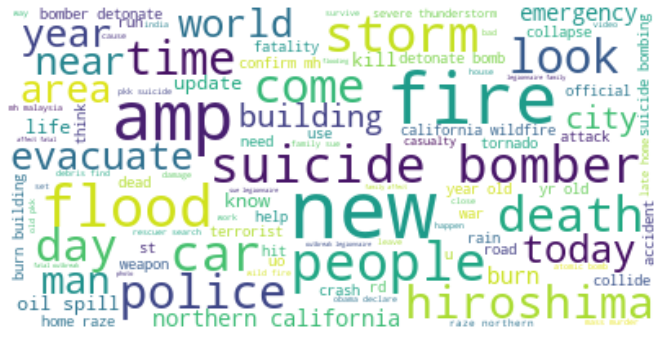

In [25]:
import matplotlib.pyplot as plt

text = " ".join(review for review in train[train['target'] == 1]['token_text'].apply(lambda x : " ".join(x)))
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
fig = plt.figure(figsize = (20, 6)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

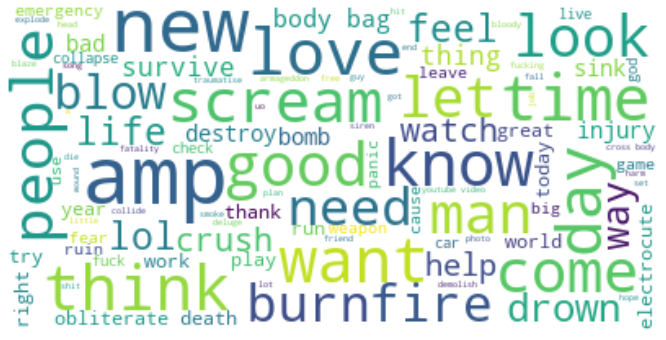

In [26]:
text = " ".join(review for review in train[train['target'] == 0]['token_text'].apply(lambda x : " ".join(x)))
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
fig = plt.figure(figsize = (20, 6)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [27]:
list_words_df3_label1 = []

for words in train[train['target'] == 1]['token_text'].tolist():
    list_words_df3_label1 += words

list_words_df3_label0 = []

for words in train[train['target'] == 0]['token_text'].tolist():
    list_words_df3_label0 += words

In [28]:
pd.DataFrame({'words':list_words_df3_label1}).value_counts().sort_values(ascending = False)[:10]

words     
#             1679
@              885
fire           268
kill           156
news           141
disaster       121
california     115
bomb           113
year           112
crash          112
dtype: int64

In [29]:
pd.DataFrame({'words':list_words_df3_label0}).value_counts().sort_values(ascending = False)[:10]

words
@        1827
#        1670
amp       193
new       172
good      120
body      119
love      117
come      108
time      106
video     103
dtype: int64

Train models. Model 1.

In [111]:
df = train.copy()

In [112]:
import numpy as np
tokenizer1 = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer1.fit_on_texts(df.keyword_text_cleaned)
df["text_encoded"] = tokenizer1.texts_to_sequences(df.text_cleaned)
df["len_text"] = df["text_encoded"].apply(lambda x: len(x))

In [113]:
df1 = df[df["len_text"]!=0]

text_pad1 = tf.keras.preprocessing.sequence.pad_sequences(df1.text_encoded, padding="post")

y = df1['target'].values

In [114]:
keyword_pad1 = tf.keras.preprocessing.sequence.pad_sequences(tokenizer1.texts_to_sequences(df1.keyword_cleaned),\
                                              padding = "post")

keyword_text_pad1 = np.concatenate([keyword_pad1,text_pad1],axis = 1)

In [129]:
X_train,X_testi,y_train,y_testi = train_test_split(keyword_text_pad1,y,test_size = 0.4,stratify = y)

X_test,X_val,y_test,y_val = train_test_split(X_testi,y_testi,test_size = 0.5, stratify = y_testi)

In [130]:
X_train.shape

(4529, 17)

In [143]:
vocab_size = tokenizer1.num_words
model1 = keras.Sequential([
                  # Couche d'Input Word Embedding  
                  keras.layers.Embedding(vocab_size+1, 128, input_shape=[X_train.shape[1],],\
                                         name="embedding"),
                  Conv1D(
filters = 14, # the number of neurons on the convolutional layer
kernel_size = (3), # the number of elements of the input the neuron will analyse at once
strides = 1, # how should the filters move along the conv dimension on the input
padding = "same", # "valid" means no padding, "same" means output shape = input shape
activation = "relu", # the activation function
kernel_regularizer = 'l2' # regularization on the neuron's parameters
),
                      keras.layers.GlobalAveragePooling1D(),
#                  keras.layers.Dense(50, activation='relu'),
                  keras.layers.Dropout(0.2),
                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),
                  keras.layers.Dropout(0.4),
#                  tf.keras.layers.Dense(8, activation='relu'),
#                  keras.layers.Dropout(0.2),
                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  keras.layers.Dense(1, activation="sigmoid")
])

In [144]:
model1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 128)           128128    
                                                                 
 conv1d_10 (Conv1D)          (None, 17, 14)            5390      
                                                                 
 global_average_pooling1d_10  (None, 14)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_23 (Dropout)        (None, 14)                0         
                                                                 
 dense_28 (Dense)            (None, 16)                240       
                                                                 
 dropout_24 (Dropout)        (None, 16)                0         
                                                     

In [145]:
optimizer= keras.optimizers.Adam()

model1.compile(optimizer=optimizer,
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

# Entrainement du modèle 
history = model1.fit(x=X_train,y=y_train,batch_size = 64, 
                    epochs=15, 
                    validation_data=(X_val,y_val),steps_per_epoch = 50)

Epoch 1/15
50/50 [==============================] - 1s 12ms/step - loss: 0.3823 - mean_absolute_error: 0.4960 - val_loss: 0.3003 - val_mean_absolute_error: 0.4909
Epoch 2/15
50/50 [==============================] - 0s 7ms/step - loss: 0.2686 - mean_absolute_error: 0.4853 - val_loss: 0.2428 - val_mean_absolute_error: 0.4761
Epoch 3/15
50/50 [==============================] - 0s 9ms/step - loss: 0.2276 - mean_absolute_error: 0.4577 - val_loss: 0.2072 - val_mean_absolute_error: 0.4354
Epoch 4/15
50/50 [==============================] - 0s 8ms/step - loss: 0.1986 - mean_absolute_error: 0.4072 - val_loss: 0.1800 - val_mean_absolute_error: 0.3849
Epoch 5/15
50/50 [==============================] - 0s 8ms/step - loss: 0.1749 - mean_absolute_error: 0.3608 - val_loss: 0.1647 - val_mean_absolute_error: 0.3466
Epoch 6/15
50/50 [==============================] - 0s 8ms/step - loss: 0.1647 - mean_absolute_error: 0.3395 - val_loss: 0.1593 - val_mean_absolute_error: 0.3304
Epoch 7/15
50/50 [=========

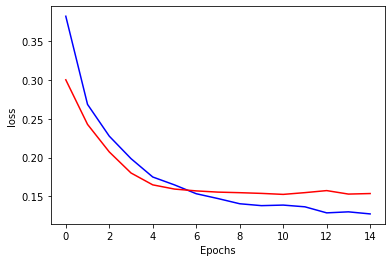

In [146]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [147]:
y_train_pred = model1.predict(X_train)
y_test_pred = model1.predict(X_test)

48/48 [==============================] - 0s 2ms/step


In [148]:
np.array(y_train).mean()

0.4318834179730625

In [149]:
np.array(y_val).mean()

0.43178807947019865

In [150]:
print('accuracy score train :' , accuracy_score(y_train,y_train_pred>0.5))
print('accuracy score test :' , accuracy_score(y_test,y_test_pred>0.5))
print('f1 score train :' , f1_score(y_train,y_train_pred>0.5))
print('f1 score test :' , f1_score(y_test,y_test_pred>0.5))

accuracy score train : 0.8670788253477589
accuracy score test : 0.7867549668874172
f1 score train : 0.8336097291321172
f1 score test : 0.7382113821138211


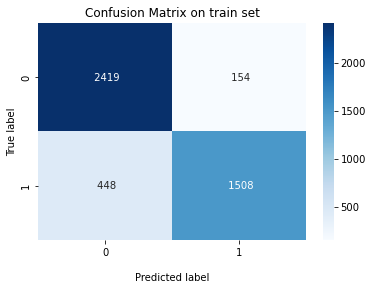

In [151]:
import seaborn as sns
ax = sns.heatmap(confusion_matrix(y_train, y_train_pred>0.5), annot=True, 
            fmt=' ', cmap='Blues')

ax.set_title('Confusion Matrix on train set');
ax.set_xlabel('\nPredicted label')
ax.set_ylabel('True label');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([0,1])
ax.yaxis.set_ticklabels([0,1])

## Display the visualization of the Confusion Matrix.
plt.show()

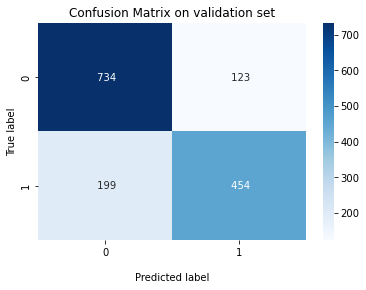

In [152]:
ax = sns.heatmap(confusion_matrix(y_test, y_test_pred>0.5), annot=True, 
            fmt=' ', cmap='Blues')

ax.set_title('Confusion Matrix on validation set');
ax.set_xlabel('\nPredicted label')
ax.set_ylabel('True label');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([0,1])
ax.yaxis.set_ticklabels([0,1])

## Display the visualization of the Confusion Matrix.
plt.show()

In [153]:
df1['pred prob target'] = model1.predict(text_pad1)
df1['pred target'] = df1['pred prob target'].apply(lambda x : x>0.5)

236/236 [==============================] - 1s 2ms/step


In [154]:
size = ((df1.target == 1)&(df1['pred target'] == 0)).sum()

idx = np.random.randint(size)

df1[(df1.target == 1)&(df1['pred target'] == 0)].iloc[idx]['text']

'perspectives on the grateful dead: critical writings (contributions to the study http://t.co/fmu0fnumxf http://t.co/aggryhvxkr'

Model2: same model than model1 but we eliminate @ and #.

In [155]:
df_bis = df.copy()

df_bis['text'] = df_bis['text'].apply(lambda x : re.sub('[@#]','',x))

tokenizer2 = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer2.fit_on_texts(df_bis.keyword_text_cleaned)
df_bis["text_encoded"] = tokenizer2.texts_to_sequences(df_bis.text_cleaned)
df_bis["len_text"] = df_bis["text_encoded"].apply(lambda x: len(x))

df2 = df_bis[df_bis["len_text"]!=0]

text_pad2 = tf.keras.preprocessing.sequence.pad_sequences(df2.text_encoded, padding="post")

y = df2['target'].values

keyword_pad2 = tf.keras.preprocessing.sequence.pad_sequences(tokenizer2.texts_to_sequences(df2.keyword_cleaned),\
                                              padding = "post")

keyword_text_pad2 = np.concatenate([keyword_pad2,text_pad2],axis = 1)

In [156]:
X_train,X_testi,y_train,y_testi = train_test_split(keyword_text_pad2,y,test_size = 0.4,stratify = y)

X_test,X_val,y_test,y_val = train_test_split(X_testi,y_testi,test_size = 0.5, stratify = y_testi)

In [157]:
vocab_size = tokenizer2.num_words
model2 = keras.Sequential([
                  # Couche d'Input Word Embedding  
                  keras.layers.Embedding(vocab_size+1, 128, input_shape=[X_train.shape[1],],\
                                         name="embedding"),
                  Conv1D(
filters = 14, # the number of neurons on the convolutional layer
kernel_size = (3), # the number of elements of the input the neuron will analyse at once
strides = 1, # how should the filters move along the conv dimension on the input
padding = "same", # "valid" means no padding, "same" means output shape = input shape
activation = "relu", # the activation function
kernel_regularizer = 'l2' # regularization on the neuron's parameters
),
                      keras.layers.GlobalAveragePooling1D(),
#                  keras.layers.Dense(50, activation='relu'),
                  keras.layers.Dropout(0.2),
                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),
                  keras.layers.Dropout(0.4),
                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  keras.layers.Dense(1, activation="sigmoid")
])

In [158]:
optimizer= keras.optimizers.Adam()

model2.compile(optimizer=optimizer,
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

# Entrainement du modèle 
history = model2.fit(x=X_train,y=y_train,batch_size = 64, 
                    epochs=6, 
                    validation_data=(X_val,y_val),steps_per_epoch = 50)

Epoch 1/6
50/50 [==============================] - 1s 11ms/step - loss: 0.3824 - mean_absolute_error: 0.4960 - val_loss: 0.3010 - val_mean_absolute_error: 0.4921
Epoch 2/6
50/50 [==============================] - 0s 8ms/step - loss: 0.2685 - mean_absolute_error: 0.4848 - val_loss: 0.2462 - val_mean_absolute_error: 0.4788
Epoch 3/6
50/50 [==============================] - 0s 8ms/step - loss: 0.2280 - mean_absolute_error: 0.4574 - val_loss: 0.2116 - val_mean_absolute_error: 0.4319
Epoch 4/6
50/50 [==============================] - 0s 8ms/step - loss: 0.1928 - mean_absolute_error: 0.3983 - val_loss: 0.1833 - val_mean_absolute_error: 0.3873
Epoch 5/6
50/50 [==============================] - 0s 8ms/step - loss: 0.1771 - mean_absolute_error: 0.3615 - val_loss: 0.1706 - val_mean_absolute_error: 0.3461
Epoch 6/6
50/50 [==============================] - 0s 8ms/step - loss: 0.1605 - mean_absolute_error: 0.3300 - val_loss: 0.1636 - val_mean_absolute_error: 0.3326


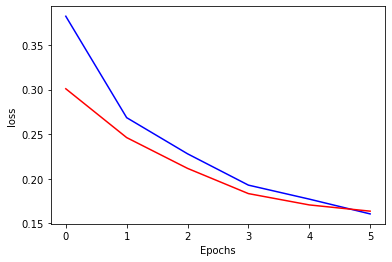

In [159]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [160]:
y_train_pred = model2.predict(X_train)
y_test_pred = model2.predict(X_test)

48/48 [==============================] - 0s 2ms/step


In [161]:
print('accuracy score train :', accuracy_score(y_train,y_train_pred>0.5))
print('accuracy score test :', accuracy_score(y_test,y_test_pred>0.5))
print('f1 score train :' , f1_score(y_train,y_train_pred>0.5))
print('f1 score test :' ,  f1_score(y_test,y_test_pred>0.5))

accuracy score train : 0.840141311547803
accuracy score test : 0.8019867549668874
f1 score train : 0.8006607929515418
f1 score test : 0.7555192150449713


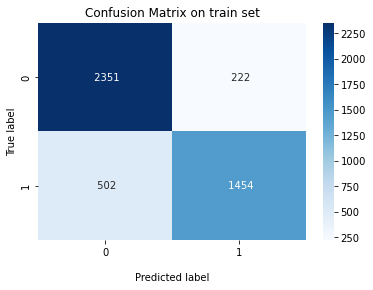

In [162]:
ax = sns.heatmap(confusion_matrix(y_train, y_train_pred>0.5), annot=True, 
            fmt=' ', cmap='Blues')

ax.set_title('Confusion Matrix on train set');
ax.set_xlabel('\nPredicted label')
ax.set_ylabel('True label');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([0,1])
ax.yaxis.set_ticklabels([0,1])

## Display the visualization of the Confusion Matrix.
plt.show()

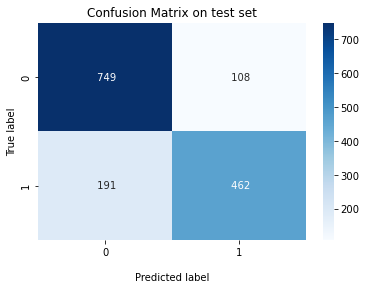

In [163]:
ax = sns.heatmap(confusion_matrix(y_test, y_test_pred>0.5), annot=True, 
            fmt=' ', cmap='Blues')

ax.set_title('Confusion Matrix on test set');
ax.set_xlabel('\nPredicted label')
ax.set_ylabel('True label');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([0,1])
ax.yaxis.set_ticklabels([0,1])

## Display the visualization of the Confusion Matrix.
plt.show()

The results are good. We now test a new model where we use Long short-term memory. 

Model3

In [164]:
tokenizer3 = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer3.fit_on_texts(df.keyword_text_cleaned)

df3 = df.copy()

tweet_pads3 = tokenizer3.texts_to_sequences(df3.text_cleaned)

In [165]:
tweet_pads3 = tf.keras.preprocessing.sequence.pad_sequences(tweet_pads3, padding="post")

In [166]:
keyword_pads3 = tokenizer3.texts_to_sequences(df3.keyword_cleaned.tolist())

In [167]:
keyword_pads3 = tf.keras.preprocessing.sequence.pad_sequences(keyword_pads3, padding="post")

In [168]:
keyword_tweet_pads3 = np.concatenate([keyword_pads3,tweet_pads3],axis = 1)

In [169]:
y = df3['target']

In [170]:
X_train,X_testi,y_train,y_testi = train_test_split(keyword_tweet_pads3,y,test_size = 0.4,stratify = y)

X_test,X_val,y_test,y_val = train_test_split(X_testi,y_testi,test_size = 0.5, stratify = y_testi)

In [171]:
X_test.shape

(1523, 17)

In [172]:
model3 = keras.models.Sequential()

model3.add(keras.layers.Embedding(vocab_size+1, 128, input_shape=[X_train.shape[1],],name="embedding"))

model3.add(keras.layers.Bidirectional(keras.layers.LSTM(15,dropout=0.2)))# LSTM layer

model3.add(keras.layers.Dropout(0.2))

model3.add(keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))

model3.add(keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))

model3.add(keras.layers.Dense(32, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))

model3.add(keras.layers.Dense(1, activation='sigmoid'))
#reg_model.name = 'L2 Regularization model'

In [173]:
model3.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 128)           128128    
                                                                 
 bidirectional (Bidirectiona  (None, 30)               17280     
 l)                                                              
                                                                 
 dropout_27 (Dropout)        (None, 30)                0         
                                                                 
 dense_32 (Dense)            (None, 64)                1984      
                                                                 
 dense_33 (Dense)            (None, 64)                4160      
                                                                 
 dense_34 (Dense)            (None, 32)                2080      
                                                     

In [174]:
optimizer= keras.optimizers.Adam()

model3.compile(optimizer=optimizer,
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

In [175]:
# Entrainement du modèle 
history = model3.fit(x=X_train,y=y_train,batch_size = 64, 
                    epochs=8, 
                    validation_data=(X_val,y_val),steps_per_epoch = 50)

Epoch 1/8
50/50 [==============================] - 7s 36ms/step - loss: 0.3496 - mean_absolute_error: 0.4811 - val_loss: 0.2939 - val_mean_absolute_error: 0.4475
Epoch 2/8
50/50 [==============================] - 1s 15ms/step - loss: 0.2385 - mean_absolute_error: 0.3531 - val_loss: 0.2251 - val_mean_absolute_error: 0.2969
Epoch 3/8
50/50 [==============================] - 1s 14ms/step - loss: 0.1810 - mean_absolute_error: 0.2799 - val_loss: 0.1973 - val_mean_absolute_error: 0.3157
Epoch 4/8
50/50 [==============================] - 1s 15ms/step - loss: 0.1555 - mean_absolute_error: 0.2550 - val_loss: 0.1841 - val_mean_absolute_error: 0.2857
Epoch 5/8
50/50 [==============================] - 1s 16ms/step - loss: 0.1375 - mean_absolute_error: 0.2356 - val_loss: 0.1887 - val_mean_absolute_error: 0.3013
Epoch 6/8
50/50 [==============================] - 1s 15ms/step - loss: 0.1341 - mean_absolute_error: 0.2371 - val_loss: 0.1834 - val_mean_absolute_error: 0.2751
Epoch 7/8
50/50 [===========

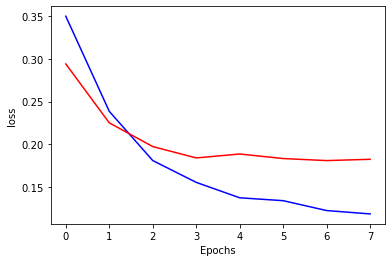

In [176]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [177]:
y_train_pred = model3.predict(X_train)
y_test_pred = model3.predict(X_test)

print('accuracy score train :' , accuracy_score(y_train,y_train_pred>0.5))
print('accuracy score test :' , accuracy_score(y_test,y_test_pred>0.5))
print('f1 score train : ' , f1_score(y_train,y_train_pred>0.5))
print('f1 score test : ' ,  f1_score(y_test,y_test_pred>0.5))

48/48 [==============================] - 0s 3ms/step
accuracy score train : 0.8892051675060214
accuracy score test : 0.7820091923834537
f1 score train :  0.8657112526539279
f1 score test :  0.7331189710610931


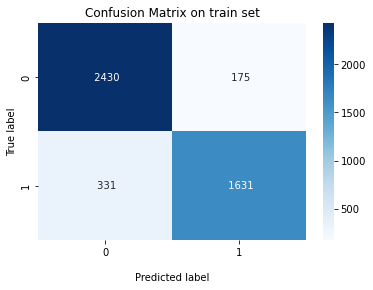

In [178]:
ax = sns.heatmap(confusion_matrix(y_train, y_train_pred>0.5), annot=True, 
            fmt=' ', cmap='Blues')

ax.set_title('Confusion Matrix on train set');
ax.set_xlabel('\nPredicted label')
ax.set_ylabel('True label');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([0,1])
ax.yaxis.set_ticklabels([0,1])

## Display the visualization of the Confusion Matrix.
plt.show()

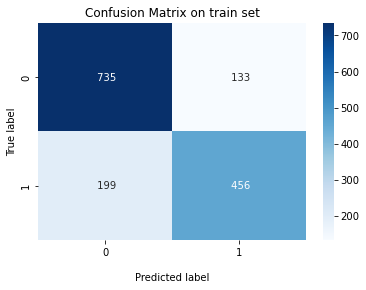

In [179]:
ax = sns.heatmap(confusion_matrix(y_test, y_test_pred>0.5), annot=True, 
            fmt=' ', cmap='Blues')

ax.set_title('Confusion Matrix on train set');
ax.set_xlabel('\nPredicted label')
ax.set_ylabel('True label');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([0,1])
ax.yaxis.set_ticklabels([0,1])

## Display the visualization of the Confusion Matrix.
plt.show()

Results are not better than model2. We now remove @ and #.

In [209]:
df_bis = df.copy()

df_bis['text'] = df_bis['text'].apply(lambda x : re.sub('[@#]','',x))

tokenizer4 = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer4.fit_on_texts(df_bis.keyword_text_cleaned)
df_bis["text_encoded"] = tokenizer4.texts_to_sequences(df_bis.text_cleaned)
df_bis["len_text"] = df_bis["text_encoded"].apply(lambda x: len(x))

df4 = df_bis[df_bis["len_text"]!=0]

text_pad4 = tf.keras.preprocessing.sequence.pad_sequences(df4.text_encoded, padding="post")

y = df4['target'].values

keyword_pad4 = tf.keras.preprocessing.sequence.pad_sequences(tokenizer4.texts_to_sequences(df4.keyword_cleaned),\
                                              padding = "post")

keyword_text_pad4 = np.concatenate([keyword_pad4,text_pad4],axis = 1)

In [210]:
X_train,X_testi,y_train,y_testi = train_test_split(keyword_text_pad4,y,test_size = 0.4,stratify = y)

X_test,X_val,y_test,y_val = train_test_split(X_testi,y_testi,test_size = 0.5, stratify = y_testi)

In [211]:
model4 = keras.models.Sequential()

model4.add(keras.layers.Embedding(vocab_size+1, 128, input_shape=[X_train.shape[1],],name="embedding"))

model4.add(keras.layers.Bidirectional(keras.layers.LSTM(15,dropout=0.2)))# LSTM layer

model4.add(keras.layers.Dropout(0.2))

model4.add(keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu', input_shape=(X_train.shape[1],)))

model4.add(keras.layers.Dense(32, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))

model4.add(keras.layers.Dense(1, activation='sigmoid'))
#reg_model.name = 'L2 Regularization model'

In [212]:
model4.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 128)           128128    
                                                                 
 bidirectional_2 (Bidirectio  (None, 30)               17280     
 nal)                                                            
                                                                 
 dropout_29 (Dropout)        (None, 30)                0         
                                                                 
 dense_39 (Dense)            (None, 64)                1984      
                                                                 
 dense_40 (Dense)            (None, 32)                2080      
                                                                 
 dense_41 (Dense)            (None, 1)                 33        
                                                     

In [213]:
optimizer= keras.optimizers.Adam()

model4.compile(optimizer=optimizer,
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

In [214]:
# Entrainement du modèle 
history = model4.fit(x=X_train,y=y_train,batch_size = 64, 
                    epochs=15, 
                    validation_data=(X_val,y_val),steps_per_epoch = 50)

Epoch 1/15
50/50 [==============================] - 7s 37ms/step - loss: 0.3024 - mean_absolute_error: 0.4794 - val_loss: 0.2601 - val_mean_absolute_error: 0.4399
Epoch 2/15
50/50 [==============================] - 1s 15ms/step - loss: 0.2129 - mean_absolute_error: 0.3569 - val_loss: 0.1865 - val_mean_absolute_error: 0.2849
Epoch 3/15
50/50 [==============================] - 1s 15ms/step - loss: 0.1697 - mean_absolute_error: 0.2832 - val_loss: 0.1738 - val_mean_absolute_error: 0.2943
Epoch 4/15
50/50 [==============================] - 1s 16ms/step - loss: 0.1392 - mean_absolute_error: 0.2403 - val_loss: 0.1726 - val_mean_absolute_error: 0.2825
Epoch 5/15
50/50 [==============================] - 1s 15ms/step - loss: 0.1331 - mean_absolute_error: 0.2360 - val_loss: 0.1733 - val_mean_absolute_error: 0.2681
Epoch 6/15
50/50 [==============================] - 1s 15ms/step - loss: 0.1254 - mean_absolute_error: 0.2308 - val_loss: 0.1747 - val_mean_absolute_error: 0.2595
Epoch 7/15
50/50 [====

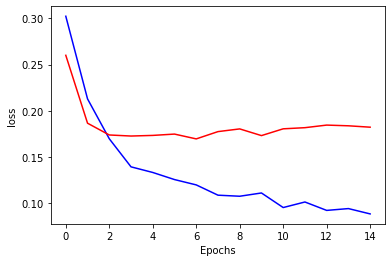

In [215]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [216]:
y_train_pred = model4.predict(X_train)
y_test_pred = model4.predict(X_test)

print('accuracy score train :' , accuracy_score(y_train,y_train_pred>0.5))
print('accuracy score test :' , accuracy_score(y_test,y_test_pred>0.5))
print('f1 score train : ' , f1_score(y_train,y_train_pred>0.5))
print('f1 score test : ' ,  f1_score(y_test,y_test_pred>0.5))

48/48 [==============================] - 0s 3ms/step
accuracy score train : 0.9085890925149039
accuracy score test : 0.7821192052980133
f1 score train :  0.888108108108108
f1 score test :  0.7274233637116819


These results are not bad. We finally use model2 in order to make prediction on the file test.csv.

In [188]:
sample = pd.read_csv('sample_submission.csv',index_col = 0)

In [189]:
test = pd.read_csv('test.csv')

In [190]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [191]:
test['keyword'] = test['keyword'].apply(replace20)

In [192]:
test['text_cleaned']=test['text'].apply(clean_text).apply(lambda x : " ".join(x))
test['text_cleaned']=test['text_cleaned'].apply(lambda x : re.sub(r'[@#]','',x))
test.head()

,id,keyword,location,text,text_cleaned
0,0,NaN,NaN,Just happened a terrible car crash,happen terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",hear earthquake different city stay safe
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee street save
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan


In [193]:
test['keyword_cleaned'] = test['keyword'].apply(clean_keyword)
test.sample(5)

,id,keyword,location,text,text_cleaned,keyword_cleaned
2953,9786,trapped,instagram- joeyparmenterr,Eric is 18 trapped in a 48 year olds buddy,eric trap year old buddy,trap
2765,9196,suicide bombing,NaN,Career goals ?? try not to cause a suicide bom...,career goal try cause suicide bombing raise ps...,suicide bombing
16,47,ablaze,Niall's place | SAF 12 SQUAD |,@sunkxssedharry will you wear shorts for race ...,sunkxssedharry wear shorace ablaze,ablaze
1614,5436,first responders,"From Boston, for New England",.@MLSudders on social workers: 'I would like u...,mlsudders social worker think responder level...,responder
941,3110,debris,Canada,Debris Found in Indian Ocean could be Malaysia...,debris find indian ocean malaysia flight,debris


In [195]:
[word for word in train['keyword_cleaned'].unique() if word not in test['keyword_cleaned'].unique()]\
+[word for word in test['keyword_cleaned'].unique() if word not in train['keyword_cleaned'].unique()]

[]

Train and test datasets have the same keywords.

In [196]:
text_encoded = tokenizer2.texts_to_sequences(test.text_cleaned)
text_pad = tf.keras.preprocessing.sequence.pad_sequences(text_encoded, padding="post")
text_pad[:5,:]

array([[276,  79,  11,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [218,  99, 927, 204, 402,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [ 78,   1, 527, 421, 155,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [207,  76,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [ 95, 514,  24, 394, 932,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])

In [197]:
text_pad.shape

(3263, 15)

In [198]:
keywords_encoded = tokenizer2.texts_to_sequences(test.keyword_cleaned)
keyword_pad = tf.keras.preprocessing.sequence.pad_sequences(keywords_encoded, padding="post")
keyword_pad.shape

(3263, 2)

In [199]:
keyword_text_pad = np.concatenate([keyword_pad,text_pad],axis = 1)
keyword_text_pad.shape

(3263, 17)

In [200]:
sample['target']=(model2.predict(keyword_text_pad)>0.5).astype(int)

102/102 [==============================] - 0s 2ms/step


In [201]:
sample.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1


In [202]:
predict1 = sample[sample.target == 1].index
predict0 = sample[sample.target == 0].index

In [207]:
idx = np.random.randint(len(predict1))

test.loc[predict1].iloc[idx]['text']

'Hiroshima: They told me to paint my story: Eighty-nine year old man recalls the terror and the trauma when the... http://t.co/VhMbN4bn0b'

In [204]:
idx = np.random.randint(len(predict0))

test.loc[predict0].iloc[idx]['text']

'Awesome!'

In [208]:
sample.to_csv('sample_submission.csv')